In [15]:
import os
import glob
import pandas as pd
import pickle
from subprocess import call
import re
from itertools import groupby
import logomaker
import matplotlib.pyplot as plt
from Bio import SeqIO

In [2]:
pre_path = "/mnt/hpc/home/xuxinran/DirectSeq/data/zhaolin_240206/240201-zhaolin-RNA-merge/v0.7.2/m6A/nano_merge"
fa_file = "/mnt/hpc/home/xuxinran/REF/hg19/hg19.fa"

In [3]:
res_path = f"{pre_path}_m6A_sites.csv"
pkl_f_path = f"{pre_path}_m6A_read_tmp_f.pkl"
pkl_r_path = f"{pre_path}_m6A_read_tmp_r.pkl"

metaPlotR_path = f"{pre_path}_metaPlotR.bed"

In [4]:
def fasta_iter(fasta_name):
    with open(fasta_name) as filename:
        faiter = (x[1] for x in groupby(filename, lambda line: line[0] == ">"))
        for header in faiter:
            header_str = next(header)[1:].strip()  # 使用next代替__next__，并修改变量名
            seq = "".join(s.strip() for s in next(faiter))  # 使用next代替__next__
            yield header_str, seq  # 使用yield代替return

def get_reverse_complementary_sequence(seq):
    seqreverse = seq[::-1]
    transtable = str.maketrans('ATGCatgc','TACGtacg')
    finalseq = seqreverse.translate(transtable)
    return finalseq

In [16]:
## 全部的site
## 此时的df里面可能会包括site不是A的位点 后期需要筛选
files_f = glob.glob(f'{pre_path}_m6A_sites_chr*_+_tmp.csv')
files_r = glob.glob(f'{pre_path}_m6A_sites_chr*_-_tmp.csv')
dfs_f = [pd.read_csv(file) for file in files_f]
dfs_r = [pd.read_csv(file) for file in files_r]
# 将这些文件的内容合并到一个 DataFrame 中
df_f = pd.concat(dfs_f, ignore_index=True)
df_r = pd.concat(dfs_r, ignore_index=True)
df = pd.concat([df_f, df_r], ignore_index=True)
df = df.sort_values(by=['chrom', 'pos_1base'])

# 找到所有匹配的文件
files_r = glob.glob(f'{pre_path}_m6A_read_chr*_-_tmp.pkl')
files_f = glob.glob(f'{pre_path}_m6A_read_chr*_+_tmp.pkl')
# 读取这些文件的内容
dicts_r = [pickle.load(open(file, 'rb')) for file in files_r]
dicts_f = [pickle.load(open(file, 'rb')) for file in files_f]
# 将这些文件的内容合并到一个字典中
merged_dict_r = {k: v for d in dicts_r for k, v in d.items()}
merged_dict_f = {k: v for d in dicts_f for k, v in d.items()}

In [17]:
## 获取motif
s = 2
e = 2

df['name'] = df['chrom'] + '_' + df['pos_1base'].astype(str)+ '_' + df['strand']
df.loc[df['strand'] == '+', 'Start'] = df.loc[df['strand'] == '+', 'pos_1base'] - s - 1
df.loc[df['strand'] == '+', 'End'] = df.loc[df['strand'] == '+', 'pos_1base'] + e
df.loc[df['strand'] == '-', 'Start'] = df.loc[df['strand'] == '-', 'pos_1base'] - e - 1
df.loc[df['strand'] == '-', 'End'] = df.loc[df['strand'] == '-', 'pos_1base'] + s
df['Start'] = df['Start'].astype(int)
df['End'] = df['End'].astype(int)
get_fasta = df[['chrom','Start','End','name']]
get_fasta.loc[:,'score'] = 0
get_fasta.loc[:,'strand'] = df['strand']
get_fasta.to_csv(f"{pre_path}.bed", header=None, sep="\t",index=False)

call(f"bedtools getfasta -name -s -fi {fa_file} -bed {pre_path}.bed -fo {pre_path}.fa",shell=True)

/tmp/ipykernel_27670/2537578925.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  get_fasta.loc[:,'score'] = 0
/tmp/ipykernel_27670/2537578925.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  get_fasta.loc[:,'strand'] = df['strand']


0

In [18]:
# motif筛选
fasta_dict = {}
with open(f"{pre_path}.fa", "r") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        fasta_dict[record.id.split("::")[0]] = str(record.seq)

df['motif_fa'] = df['name'].apply(lambda x: fasta_dict[x])
df['base'] = df['motif_fa'].apply(lambda x: x[2])

df_save = df[(df['base']=="A")|(df['base']=="a")]
df_save = df_save[['chrom','pos_1base','strand','methy_num', "cov", 'methy_rate', 'motif']]
df_save.to_csv(res_path, index=False)

df_save['pos_0base'] = df_save['pos_1base'] - 1
df_save['k'] = df_save['chrom'] + '_' + df_save['pos_0base'].astype(str) + '_' + df_save['strand']
readid_set = set(df_save['k'])
filtered_merged_dict_r = {key: value for key, value in merged_dict_r.items() if key in readid_set}
filtered_merged_dict_f = {key: value for key, value in merged_dict_f.items() if key in readid_set}
with open(pkl_r_path, 'wb') as file:
    pickle.dump(filtered_merged_dict_r, file)
with open(pkl_f_path, 'wb') as file:
    pickle.dump(filtered_merged_dict_f, file)

In [20]:
call(f'rm {pre_path}.bed {pre_path}.fa {pre_path}_m6A_read_chr*_tmp.pkl {pre_path}_m6A_sites_chr*_tmp.csv',shell=True)

0

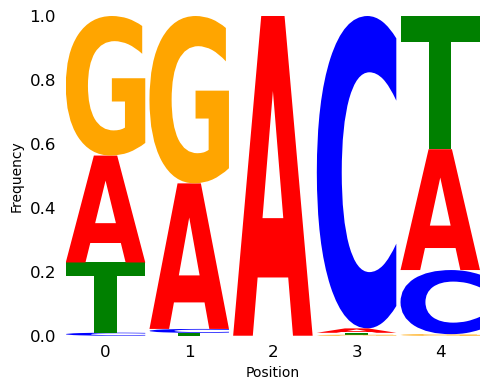

In [19]:
# 绘制motif图
df_save = df[(df['base']=="A")|(df['base']=="a")]
sequences = df_save['motif_fa'].str.upper().tolist()
# 计算频率矩阵
counts_df = logomaker.alignment_to_matrix(sequences, to_type='counts')

# 将counts矩阵转化为比例矩阵
freq_df = counts_df.div(counts_df.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(5, 4)) # 5位

# 创建序列logo
logo = logomaker.Logo(freq_df, ax=ax)
# 设置颜色方案
color_scheme = {
    'A': 'red',
    'C': 'blue',
    'G': 'orange',
    'T': 'green'
}
logo.style_glyphs(color_scheme=color_scheme)
# 调整logo样式
logo.style_spines(visible=False)
logo.style_spines(spines=['left', 'bottom'], visible=True)
logo.ax.set_ylabel('Frequency')
logo.ax.set_xlabel('Position')
logo.ax.xaxis.set_ticks_position('none')
logo.ax.yaxis.set_ticks_position('none')
logo.ax.xaxis.set_tick_params(width=0)
logo.ax.yaxis.set_tick_params(width=0)

# 调整字体宽度和紧凑度
for spine in ax.spines.values():
    spine.set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# 显示logo
plt.show()


In [9]:
## 生成metaPlotR文件
df_metaPlotR = df[(df['base']=="A")|(df['base']=="a")]
df_metaPlotR = df_metaPlotR[(df_metaPlotR['cov']>10)&(df_metaPlotR['methy_rate']>50)]
df_metaPlotR['pos_0base'] = df_metaPlotR['pos_1base'] - 1
df_metaPlotR['ratio'] = df_metaPlotR['methy_rate'].astype(float)/100
df_metaPlotR['index'] = pd.Series(range(1, len(df_metaPlotR) + 1))
df_metaPlotR = df_metaPlotR[['chrom', 'pos_0base', 'pos_1base','index', 'ratio','strand']]
df_metaPlotR.to_csv(metaPlotR_path, index=False,sep="\t",header=False)
